---
# Tutorial Objectives

In this tutorial we will learn how to track objects in 3D on the KITTI dataset. We will build off of our object dector from part 1 and use each obejct detection to update the tracks.

For more information a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT), and a paper that details the data collection and coordinate systems can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf).


<br>

## Get the data

In [1]:
## Kitti raw 데이터셋 다운로드 및 압축 해제

!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

!jar xf 2011_10_03_drive_0047_sync.zip
!jar xf 2011_10_03_calib.zip

--2024-08-13 13:41:03--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.136.182, 52.219.75.163, 3.5.137.186, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.136.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  4.20MB/s    in 11m 57s 

2024-08-13 13:53:02 (4.13 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]

--2024-08-13 13:53:02--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.169.113, 52.219.75.135, 3.5.134.197, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.169.113|:443..

## Base Library Import

In [3]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

## Import Utility functions

In [8]:
!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
from kitti_utils import *

!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_detection_utils.py
from kitti_detection_utils import *

--2024-08-13 14:36:23--  https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
Resolving github.com (github.com)... 20.200.245.247
Connecting to github.com (github.com)|20.200.245.247|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py [following]
--2024-08-13 14:36:23--  https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9759 (9.5K) [text/plain]
Saving to: ‘kitti_utils.py’

kitti_utils.py      100%[===================>]   9.53K  --.-KB/s    in 0s      

2024-08-13 14:36:23 (23.4 MB/s) - ‘kitti_utils.py’ saved [9759/9759]

--2024-08-

## Get Data Paths

In [9]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837
Number of GPS/IMU frames: 837


Since we will be using a Kalman Filter for 3D space, we will need to use the time stamp data. We will be fusing data from Camera 2 and the LiDAR, both of those time stamps are slightly misaligned, but they time delta is generally negligable for this purpose. We will opt to use the Camera 2 time stamps for out Kalman Filter.

In [10]:
get_total_seconds = lambda hms: hms[0]*60*60 + hms[1]*60 + hms[2]


def timestamps2seconds(timestamp_path):
    ''' Reads in timestamp path and returns total seconds (does not account for day rollover '''
    timestamps = pd.read_csv(timestamp_path,
                             header=None)
    timestamps = timestamps.squeeze('columns').astype(object) \
                                          .apply(lambda x: x.split(' ')[1])

    # Get Hours, Minutes, and Seconds
    hours = timestamps.apply(lambda x: x.split(':')[0]).astype(np.float64)
    minutes = timestamps.apply(lambda x: x.split(':')[1]).astype(np.float64)
    seconds = timestamps.apply(lambda x: x.split(':')[2]).astype(np.float64)

    hms_vals = np.vstack((hours, minutes, seconds)).T

    total_seconds = np.array(list(map(get_total_seconds, hms_vals)))

    return total_seconds

In [11]:
cam2_total_seconds = timestamps2seconds(os.path.join(DATA_PATH, r'image_02/timestamps.txt'))
print(f'Number of time stamps: {len(cam2_total_seconds)}')

Number of time stamps: 837


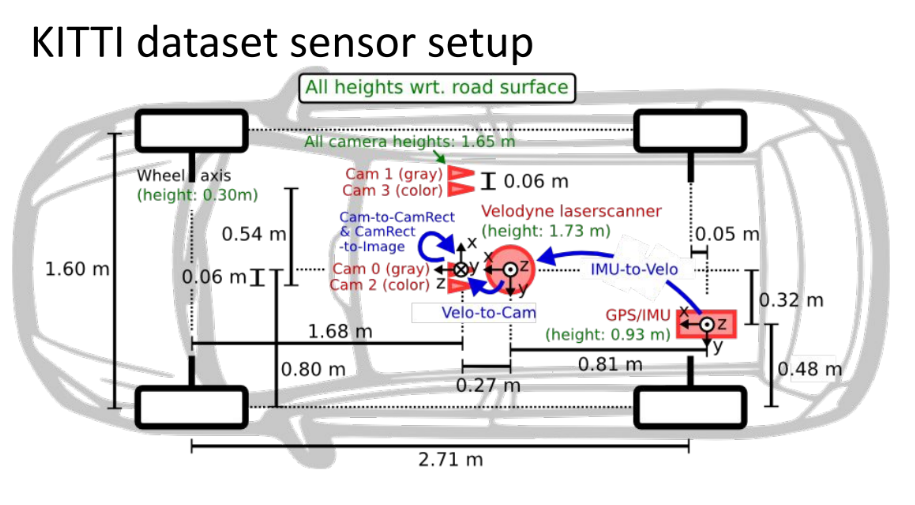

## Get Camera Transformation Matrices

In [12]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices (rectified left camera --> left camera (u,v,z))
# Rectified 2번 카메라 좌표계에서 2번 카메라 (u,v,z) 좌표계로의 변환
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera) #R_rect_02
# 2번 카메라 좌표계로부터 Rectified 2번 카메라 좌표계로의 회전 변환
R_ref2_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_ref2_rect2 = np.insert(R_ref2_rect2, 3, values=[0,0,0], axis=0)
R_ref2_rect2 = np.insert(R_ref2_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2 #R_02 #T_02
# 0번 카메라 좌표계로부터 2번 카메라 좌표계로의 변환
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

## Get LiDAR and IMU Transformation matrices

In [13]:
# 라이다 좌표계로부터 0번 카메라 좌표계로의 변환
T_velo_ref0 = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')

# IMU 좌표계로부터 라이다 좌표계로의 변환
T_imu_velo = get_rigid_transformation(r'2011_10_03/calib_imu_to_velo.txt')

#### Get LiDAR ⬌ Camera2 Rotation matrices



In [14]:
# transform from velo (LiDAR) to left color camera (shape 3x4)

### TODO Ref0 카메라 좌표계에 대한 LiDAR 좌표 변환(T_velo_ref0) 를 안다고 할 때, 이 LiDAR 좌표를 카메라 2 (u,v,z) 좌표계에 맞추시오 ###
T_velo_cam2 = P_rect2_cam2 @ R_ref2_rect2 @ T_ref0_ref2 @ T_velo_ref0

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0))

#### Get IMU ⬌ Camera2 Rotation matrices


In [15]:
### TODO IMU 좌표계에 대한 LiDAR 좌표 변환(T_imu_velo) 를 안다고 할 때, 이 LiDAR 좌표를 카메라 2 (u,v,z) 좌표계에 맞추시오 ###
T_imu_cam2 = T_velo_cam2 @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0))

## **Get Object Detection pipeline**

In [26]:
# 2D object detector 로 YOLOv5 사용

!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt  #Install whatever is needed

Cloning into 'yolov5'...
remote: Enumerating objects: 16843, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 16843 (delta 4), reused 10 (delta 0), pack-reused 16825
Receiving objects: 100% (16843/16843), 15.58 MiB | 16.53 MiB/s, done.
Resolving deltas: 100% (11548/11548), done.
  Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0


In [31]:
## YOLOv5 제공 체크포인트 다운로드
#!pip install pillow==9.0.0
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/devrok/.cache/torch/hub/master.zip


requirements: Ultralytics requirement ['pillow>=10.3.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.0
    Uninstalling Pillow-9.0.0:
      Successfully uninstalled Pillow-9.0.0

requirements: AutoUpdate success ✅ 2.7s, installed 1 package: ['pillow>=10.3.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-8-13 Python-3.10.14 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 20.3MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [32]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [33]:
!wget https://github.com/ultralytics/yolov5/raw/master/data/coco.yaml

--2024-08-13 14:57:26--  https://github.com/ultralytics/yolov5/raw/master/data/coco.yaml
Resolving github.com (github.com)... 20.200.245.247
Connecting to github.com (github.com)|20.200.245.247|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ultralytics/yolov5/master/data/coco.yaml [following]
--2024-08-13 14:57:27--  https://raw.githubusercontent.com/ultralytics/yolov5/master/data/coco.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489 (2.4K) [text/plain]
Saving to: ‘coco.yaml’

coco.yaml           100%[===================>]   2.43K  --.-KB/s    in 0s      

2024-08-13 14:57:27 (16.1 MB/s) - ‘coco.yaml’ saved [2489/2489]



In [34]:
import yaml

with open('coco.yaml', "r") as stream:
    try:
        classes = yaml.safe_load(stream)['names']
    except yaml.YAMLError as exc:
        print(exc)

In [35]:
def get_color(idx):
    '''returns a random color seeded from the input index '''
    blue = idx*5 % 256
    green = idx*15 % 256
    red = idx*25 % 256
    return (red, green, blue)


def draw_boxes(image_in, boxes, categories, color, mot_mode=False):
    image = image_in.copy()
    h, w, _ = image.shape
    for i, box in enumerate(boxes):
        label = classes[int(categories[i])]
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, thickness=2)
        cv2.putText(image, str(label), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    return image

In [36]:
!pip install filterpy

  Using cached filterpy-1.4.5-py3-none-any.whl


In [37]:
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

def constantVelocity_KF(R_std, Q_std, dt):
    ''' creates and instantiates a filterpy 2D Kalman Filter object
        with a 3D constant velocity model
        Inputs:
            R_Std (float) - measurement uncertainty
            Q_std (float) - Proccess noise covariance
            dt (float) - System Time Step
        Outputs:
            kf (filterpy object) 3D Kalman Filter object
    '''
    kf = KalmanFilter(dim_x=6, dim_z=3)
    kf.x = np.array([10., 0., 0., 0., 0., 0.]) # initial state 10m in front of ego
    kf.P = np.eye(6)*1000
    q = Q_discrete_white_noise(dim=3, dt=dt, var=Q_std**2)
    kf.Q = block_diag(q, q) # Process noise covariance
    kf.R = np.eye(3) * R_std**2 # measurement uncertainty/noise
    kf.H = np.array([[1, 0, 0, 0, 0, 0],  # measurement function
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0]])

    kf.F = np.array([[1, dt, 0, 0,  0, 0 ],     # state transition matrix
                     [0, 1,  0, 0,  0, 0 ],
                     [0, 0,  1, dt, 0, 0 ],
                     [0, 0,  0, 1,  0, 0 ],
                     [0, 0,  0, 0,  1, dt],
                     [0, 0,  0, 0,  0, 1 ]])

    return kf

In [38]:
np.median(np.diff(cam2_total_seconds))

0.10361651199491462

In [39]:
# define measurement noise std dev and process noise std dev
R_std = 0.1 # measurement uncertainty
Q_std = 0.35 #  process noise
dt = np.median(np.diff(cam2_total_seconds))

kf = constantVelocity_KF(R_std, Q_std, dt)

In [40]:
print(kf.x)
kf.predict() ## 상태값 예측
print(kf.x)
kf.update((17, 16, 0.003)) ## 예측한 상태값과 Measurement 로 상태 업데이트
print(kf.x, 'update')

kf.predict()
print(kf.x)
kf.update((17.5, 15, 0.003))
print(kf.x, 'update')

kf.predict()
print(kf.x)
kf.update((17.8, 15, 0.003))
print(kf.x, 'update')

kf.predict()
print(kf.x)
kf.update((18, 14.9, 0.003))
print(kf.x, 'update')

kf.predict()
print(kf.x)
kf.update((18.1, 14.07, 0.003))
print(kf.x, 'update')

kf.predict()
print(kf.x)

[         10           0           0           0           0           0]
[         10           0           0           0           0           0]
[         17      0.7178          16        1.64       0.003  0.00030758] update
[     17.074      0.7178       16.17        1.64   0.0030318  0.00030758]
[       17.5      4.8177      15.001     -9.5001       0.003  8.5309e-07] update
[     17.999      4.8177      14.017     -9.5001   0.0030001  8.5309e-07]
[     17.833      3.8794      14.968     -4.7638       0.003  3.7355e-07] update
[     18.235      3.8794      14.474     -4.7638   0.0030001  3.7355e-07]
[      18.07      3.2113       14.88     -3.3779   0.0030026  3.6326e-05] update
[     18.403      3.2113       14.53     -3.3779   0.0030063  3.6326e-05]
[     18.221       2.607      14.094     -4.3504   0.0029945 -6.5808e-05] update
[     18.492       2.607      13.643     -4.3504   0.0029877 -6.5808e-05]


## **Set up tracking pipeline**

The tracking will be a 3D real world extension of the [SORT algorithm](https://arxiv.org/pdf/1602.00763.pdf). \
Instead of tracking bounding box location and aspect, we will **simple track the (x, y, z) locations of each detected object**. Even though we can esily neglect the z-axis, we will include it to keep our coordinate trasnformations easier.

In our **Kalman Filter we will use a constant velocity model** with a random accleration assumption.

The tracking pipeline will use the object detection methods from YOLOv5 as a backbone.

The **L2 distance between object (x,y,z) centers will be used as a cost.**

The Hungarian Algorithm (linear_sum_assignemnt in Python) will be used to match old tracks with new updates and determine if tracks are not updated.

Even though an autonomous vehicle does not need bounding boxes, we will still implement them in our tracker.
We will **need to rotate the updated IMU (x,y,z) to the Camera (u,v,z)** which will serve as the new location for the bounding box.

In [41]:
from scipy.optimize import linear_sum_assignment

## 두 Object center를 입력으로 받아, center의 L2 distance를 도출하는 함수
def total_cost(center1, center2):
    ''' Return L2 distance between object centers '''

    ### TODO 두 center 간의 L2 distance를 도출하세요 ###
    return np.linalg.norm(center1-center2)

def associate(old_centers, new_centers, dist_thresh=1):
    """
    Inputs:
        old_centers - former center locations (at time 0)
        new_centers - new center locations (at time 1)
        dist_thresh - distance threshold to declare tracks matched or unmatched
    Outputs:
       matches - Matched tracks
       unmatched_detections - Unmatched Detections
       unmatched_trackers - Unmatched Tracks

    """
    if (len(new_centers) == 0) and (len(old_centers) == 0):
        return [], [], []
    elif(len(old_centers)==0):
        return [], new_centers, []
    elif(len(new_centers)==0):
        return [], [], old_centers

    # distances는 Object center 간의 L2 distance를 저장
    distances = np.zeros((len(old_centers),len(new_centers)),dtype=np.float32)

    ### TODO 이중 for loop 를 통해 모든 old_center들과 new_center들 간의 L2 distance를 distances 변수에 저장하세요 ###
    for i,old_cntr in enumerate(old_centers):
        for j,new_cntr in enumerate(new_centers):
                distances[i][j] = total_cost(old_cntr, new_cntr)

    # Hungarian Algorithm (L2 distance metric을 cost로 사용)
    ## Hungarian Algorithm은 costmap 에서 전체 cost가 가장 작아지는 방향으로 매칭되는 행과 열을 반환
    row_ind, col_ind = linear_sum_assignment(distances)
    hungarian_matrix = np.array(list(zip(row_ind, col_ind)))

    matches, unmatched_detections, unmatched_tracks = [], [], []

    # Hungarian Matrix를 순회하며 Hungarian algorithm이 매칭시킨 요소 탐색
    for h in hungarian_matrix:
        #### TODO 매칭된 요소 간 거리가 threshold distance 이상이면 해당 old_center와 new_center를 unmatched에 추가####
        if(distances[h[0],h[1]] > dist_thresh):
            unmatched_tracks.append(old_centers[h[0]])
            unmatched_detections.append(new_centers[h[1]])

        #### TODO 그렇지 않으면 매칭에 추가 ####
        else:
            matches.append(h.reshape(1,2))

    if(len(matches)==0):
        matches = np.empty((0,2), dtype=int)
    else:
        matches = np.concatenate(matches, axis=0)

    # old_center들을 순회하며, 매칭된 탐지가 없으면 unmatched_tracks에 추가
    for t, trk in enumerate(old_centers):
        if(t not in hungarian_matrix[:,0]):
            unmatched_tracks.append(trk)

    # new_center들을 순회하며, 매칭된 트랙이 없으면 unmatched_new_centers에 추가
    for d, det in enumerate(new_centers):
        if(d not in hungarian_matrix[:,1]):
            unmatched_detections.append(det)

    return matches, unmatched_detections, unmatched_tracks

In [42]:
REF_IMAGE = cv2.imread(left_image_paths[0])

def xyz2uvz(xyz):
    ''' converts IMU xyz to Cam 2 UVZ '''
    xyzw = np.hstack((xyz, 1))[:, None]
    uvz = xyzw2camera(xyzw, T_imu_cam2, REF_IMAGE)

    return uvz

In [43]:
class Track():
    def __init__(self, idx, xyz, color, bbox=None, cat=0, kf=None):
        '''
          idx - track index
          xyz - track center in IMU (x, y, z) coordinates
          color - color for the object and it's bounding box
          bbox - (1x4 array) bounding box (x,y) coordiantes
               We will only care about the bounding box until the object has
               been matched
          cat - track category
          kf - KalmanFilter Object for tracking
          age - track age, number of frames track has been observed
          hit_streak - simultaneuos hits
          unmatched_age - number of frames track has not been observed
          fov - (_Bool) indicates that the object is approaching edge of FOV
          '''
        # set inputs
        self.idx = idx
        self.xyz = xyz
        self.color = color
        self.bbox = bbox
        self.cat = cat
        self.kf = kf

        # everything else
        self.uvz = None # uvz image location of object
        self.hit_streak = 1
        self.age = 0 # number of frames track has not been observed
        self.fov = 0 # indicates that the object is approaching edge of FOV
        self.history = [xyz] # initialize track (x,y,z) history


    def update(self, new_xyz):
        ''' Update function for a given track object '''

        # update Kalman Filter State with new observation
        self.kf.update(new_xyz)

        # update track file position
        self.xyz = new_xyz

        # update uvz image location
        self.uvz = xyz2uvz(self.xyz)

        # reset age
        self.age = 0

        # update history
        self.history.append(self.xyz)


    def predict(self):
        ''' predicts new track location and updates it's bounding box '''
        # predict new location
        self.kf.predict()

        # update track state after KF prediction
        self.xyz = self.kf.x[::2] # get positions only

        # update bounding box in image coordinate
        if isinstance(self.bbox, np.ndarray):
            if self.uvz.all():
                self.update_bbox(self.uvz)


    def update_bbox(self, new_uvz):
        '''updates bounding box to new location based on new uvz center coordinates
          from the IMU. To be used during Kalman Filter updates.
          '''
        width = self.bbox[2] - self.bbox[0]
        height = self.bbox[3] - self.bbox[1]

        x1 = np.round(new_uvz[0] - width/2.).astype(int)
        x2 = np.round(new_uvz[0] + width/2.).astype(int)

        y1 = np.round(new_uvz[1] - height/2.).astype(int)
        y2 = np.round(new_uvz[1] + height/2.).astype(int)

        self.bbox = np.array([x1, y1, x2, y2]).squeeze()

In [44]:
class Tracker():
    def __init__(self,  max_age=3, min_hits=2, dist_threshold=1):
        '''
            Inputs:
                max_age - max number of updates for a track to be declared lost
                min_hits - minnumber of hits/matches for a track to be declared
                dist_threshold - min L2 distance for a track to be considered
            Outputs:
                ret_tracks - returned tracks list after min hits and age out
            '''
        self.max_age = max_age
        self.min_hits = min_hits
        self.dist_threshold = dist_threshold
        self.tracks = []
        self.track_idx = 0 # unique track index
        self.frame_count = 0 # frames

    def update(self, detections, det_info):
        ''' Update the tracks with new detections
            Inputs:
                detections - Nx3 array of (x, y, z) object locations
                det_info - Nx6 array of bounding boxes, confidence, and category
                           for each detection
            Outputs:
                ret_tracks - list of new track objects that are filtered
                    out based on min hits required for a track to be shown
            '''
        # unpack detection info
        bboxes = det_info[:, :4]
        categories = det_info[:, 5]

        # increment frame count
        self.frame_count += 1

        # get current track centers for association
        tracks_xyz = [trk.xyz for trk in self.tracks]

        # associate new detections with current tracks (Hungarian)
        matches, unmatched_dets, unmatched_trks = associate(tracks_xyz,
                                                            detections,
                                                            self.dist_threshold)

        # get returnable tracks list
        ret_tracks = []

        # update matches
        for (old_idx, new_idx) in matches:

            # get new detection coordinates
            new_xyz = detections[new_idx]

            #### TODO update KF with new observation ####
            self.tracks[old_idx].update(new_xyz)

            # update bounding box with new detection
            self.tracks[old_idx].bbox = np.round(bboxes[new_idx]).astype(int)

            #### TODO predict KF ####
            self.tracks[old_idx].predict()

            # update hit streak
            self.tracks[old_idx].hit_streak += 1

            # add category to track file
            self.tracks[old_idx].cat = categories[new_idx]

            #### TODO if hit_streak is big enough, append to ret_tracks ####
            if self.tracks[old_idx].hit_streak >= self.min_hits:
                ret_tracks.append(self.tracks[old_idx])


        # get indexes of tracks to delete
        to_del = []

        # handle unmatched observations
        for old_xyz in unmatched_trks:

            # get old track index
            trk_idx = np.where(tracks_xyz == old_xyz)[0][0]

            # increment track age
            self.tracks[trk_idx].age += 1

            # reset hit streak
            self.tracks[trk_idx].hit_streak = 0

            #### TODO track age 가 max_age보다 넘는다면 to_del list에 추가 ####
            if self.tracks[trk_idx].age >= self.max_age:
                to_del.append(trk_idx)

            #### TODO track age 가 max_age보다 작다면 계속 prediction 진행 ####
            else:
                self.tracks[trk_idx].predict()

                # add to new tracks if old enough and has been matched
                # only matched tracks have a bbox
                if (len(self.tracks[trk_idx].history) >= self.min_hits) \
                    and (isinstance(self.tracks[trk_idx].bbox, np.ndarray)):
                    ret_tracks.append(self.tracks[trk_idx])

        # delete tracks
        self.tracks[:] = [trk for i, trk in enumerate(self.tracks)
                                                      if i not in to_del]

        # get new observations
        for new_xyz in unmatched_dets:

            # get new track
            # add to the index to get brighter colors
            color = get_color(self.track_idx + np.random.randint(25, 100))

            #### TODO 새로운 bbox observation에 대해 새로운 kf 할당, track 생성 ####
            kf = constantVelocity_KF(R_std, Q_std, dt)
            track = Track(self.track_idx, new_xyz, color, kf=kf)

            # incerement unique track indexes
            self.track_idx += 1

            # add to tracks list
            self.tracks.append(track)

        return ret_tracks

    def seed(self, detections):
        ''' seeds the tracker with initial detections '''
        pass

## **Tracking Pipeline**

In [45]:
#### Utils for get_detections (Object Detector)####

def project_velobin2uvz(bin_path, T_uvz_velo, image, remove_plane=True):
    ''' Projects LiDAR point cloud onto the image coordinate frame (u, v, z)
        '''

    # get homogeneous LiDAR points from bin file
    xyzw = bin2xyzw(bin_path, remove_plane)

    # project velo (x, z, y, w) onto camera (u, v, z) coordinates
    velo_uvz = xyzw2camera(xyzw, T_uvz_velo, image, remove_outliers=True)

    return velo_uvz

def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    ''' Obtains detected object centers projected to uvz camera coordinates.
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the uvz
        camera reference and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          bboxes_out - modified array containing the object centers projected
                       to uvz image coordinates
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))
                              - np.array([[obj_x_center, obj_y_center]]).T)

        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])

        # add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int),
                             np.round(obj_x_center).astype(int))
            cv2.putText(image,
                        '{0:.2f} m'.format(velo_depth),
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)

    return bboxes_out

def get_detection_coordinates(image, bin_path, model, T_velo_cam, draw_boxes=True, draw_depth=True):
    ''' Obtains detections for the input image, along with the coordinates of
        the detected object centers. The coordinate obtained are:
            - Camera with depth --> uvz
            - LiDAR/velo --> xyz
            - GPS/IMU --> xyz
        Inputs:
            image - rgb image to run detection on
            bin_path - path to LiDAR bin file
            T_velo_cam - transformation from LiDAR to camera## (u,v,z) space
            model - detection model (this functions assumes a yolo5 model)
                  - any detector can be used as long as it has the following attributes:
                    show, xyxy
        Output:
            bboxes - array of detected bounding boxes, confidences, classes,
            velo_uv - LiDAR points porjected to camera uvz coordinate frame
            coordinates - array of all object center coordinates in the frames
                          listed above
        '''
    ## 1. compute detections in the left image
    detections = model(image)

    # draw boxes on image
    if draw_boxes:
        detections.show()

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu() # remove from GPU

    # get LiDAR points and transform them to image/camera space
    velo_uvz = project_velobin2uvz(bin_path,
                                   T_velo_cam,
                                   image,
                                   remove_plane=True)

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(image,
                             velo_uvz,
                             bboxes,
                             draw=draw_depth)

    return bboxes, velo_uvz

In [46]:
def get_detections(image, bin_path, model, T_velo_cam, T_cam_imu):
     ''' Obtains (x,y,z) locations referenced to IMU and image bounding boxes
         Camera reference specified by image and Transformation Matrices,
         Can use any camera as the reference
         '''
     # get detections and object centers in uvz
     bboxes, velo_uvz = get_detection_coordinates(image,
                                                  bin_path,
                                                  model,
                                                  T_velo_cam,
                                                  draw_boxes=False,
                                                  draw_depth=False)

     # get transformed coordinates of object centers
     uvz = bboxes[:, -3:]

     # transform to IMU (u,v,z)
     imu_xyz = transform_uvz(uvz, T_cam_imu)

     return imu_xyz, bboxes, velo_uvz

In [50]:
import warnings

# FutureWarning을 무시
warnings.filterwarnings("ignore", category=FutureWarning)

# initiate the tracker
tracker = Tracker(max_age=5, min_hits=2, dist_threshold=1.75)

# results
result_video = []

# iterate through all frames
for index in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
    bin_path = bin_paths[index]

    # get detections from Camera-LiDAR fusion
    imu_xyz, bboxes, velo_uvz = get_detections(left_image, bin_path, model, T_velo_cam2, T_cam2_imu)

    # get tracks from Tracker by taking new observations
    new_tracks = tracker.update(imu_xyz, bboxes[:, :6])

    # draw projected velo on blank image
    velo_image = np.zeros_like(left_image)

    # draw boxes and labels on new tracks
    for trk in new_tracks:

        if trk.uvz.all():

            # draw bounding box on the tracked object
            xy1 = (trk.bbox[0], trk.bbox[1])
            xy2 = (trk.bbox[2], trk.bbox[3])
            cv2.rectangle(left_image, xy1, xy2, trk.color, 2);

            # draw track label on image (cat_idx)
            label = str(classes[int(trk.cat)] + '_' + str(trk.idx))
            cv2.putText(left_image, label, (trk.bbox[0] - 10, trk.bbox[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, trk.color, 2, cv2.LINE_AA);


            # draw points on velo image
            velo_box = velo_uvz[:, ((velo_uvz[0, :] <= trk.bbox[2]) & (velo_uvz[0, :] >= trk.bbox[0]))
                                  & ((velo_uvz[1, :] <= trk.bbox[3]) & (velo_uvz[1, :] >= trk.bbox[1]))]

            draw_velo_on_image(velo_box, velo_image)


            # draw slant range on left image and velo image
            object_center = (np.round(trk.uvz[0][0]).astype(int),
                            np.round(trk.uvz[1][0]).astype(int))
            cv2.putText(left_image,
                        '{0:.2f} m'.format(np.linalg.norm(trk.xyz)),
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)
            cv2.putText(velo_image,
                        '{0:.2f} m'.format(np.linalg.norm(trk.xyz)),
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)

    # get stacked frame
    stacked = np.vstack((left_image, velo_image))

    # append to results
    result_video.append(stacked)

### Store results in a video

In [51]:
# camera 2 frames per second
cam2_fps = 1/np.median(np.diff(cam2_total_seconds))
cam2_fps

9.650971459539951

In [52]:
h, w, _ = stacked.shape
out = cv2.VideoWriter('track_vid_stacked_with_filter_1.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'),
                      cam2_fps,
                      (w,h))

for img in result_video:
    out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
